In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from datetime import datetime
from datetime import timedelta

from matplotlib import style
from matplotlib.dates import DateFormatter, AutoDateLocator

from scipy import stats

## Definice funkci

In [ ]:
#region Tvorba vlastnich atributu

# vraci dvojici (dict/L3, dict/L4) ktery priradi kazde komunikaci v df unikatni identifikator
# d_l3: klic je tuple (srcIP, dstIP) a hodnota je nove vygenerovane id komunikace
# d_l4: klic je tuple (srcIP, srcPort, dstIP, dstPort) a hodnota je nove vygenerovane id komunikace
def find_communication_pairs(df: pd.DataFrame) -> tuple:
    d_l3 = dict()
    d_l4 = dict()
    i, j = 1, 1
    for (srcIP, srcPort, dstIP, dstPort) in zip(df.srcIP, df.srcPort, df.dstIP, df.dstPort):
        # L3
        if (srcIP, dstIP) not in d_l3:
            d_l3[(srcIP, dstIP)] = i
            i = i + 1
        
        # L4
        if (srcIP, srcPort, dstIP, dstPort) not in d_l4:
            d_l4[(srcIP, srcPort, dstIP, dstPort)] = j
            j = j + 1

    return d_l3, d_l4

# vraci list ktery priradi kazdemu zaznamu v df relativni cislo oznacujici den
# nesmi byt mezi casy mezera vetsi nez 24h (jinak se packety priradi nespravne do jednoho dne)
# [0..0, 1..1, 2..2, 3..3, ...]
def find_relative_days(df: pd.DataFrame) -> list:
    # krajni pripady
    if len(df.index) == 0:
        return []
    if len(df.index) == 1:
        return [0]

    # jadro funkce
    l = [0]
    counter = 0
    for i in range(1, len(df.index)):
        if df['TimeStamp'][i].time() < df['TimeStamp'][i-1].time():
            counter += 1
        l.append(counter)
    return l

#endregion

#region Filtry

# Vraci df vyfiltrovany podle absolutniho casu (vcetne hranicnich hodnot)
def filter_by_time_abs(df: pd.DataFrame, start: datetime, end: datetime) -> pd.DataFrame:
    return df[(df['TimeStamp'] >= start) & (df['TimeStamp'] <= end)]

# Vraci df vyfiltrovany podle relativniho casu (vcetne hranicnich hodnot)
def filter_by_time_rel(df: pd.DataFrame, end: float) -> pd.DataFrame:
    return filter_by_time_rel(df, 0.0, end)

def filter_by_time_rel(df: pd.DataFrame, start: float, end: float) -> pd.DataFrame:
    return df[(df['Relative Time'] >= start) & (df['Relative Time'] <= end)]

#endregion

## Nacteni a predzpracovani dataframu

In [ ]:
# Nacteni df
file = "data/mega104-14-12-18-ioa.csv"
# file = "data/mega104-17-12-18-ioa.csv"
df = pd.read_csv(file, sep=";", dtype={'asduType':'category', 'numix':'category', 'cot':'category', 'uType':'category', 'oa':'category'})


# prida sloupce 'commL3Id' a 'commL4Id' do dataframu s id komunikaci
cp_l3, cp_l4 = find_communication_pairs(df)
df['commL3Id'] = df.apply(lambda row: cp_l3[(row.srcIP, row.dstIP)], axis=1).astype("category")
df['commL4Id'] = df.apply(lambda row: cp_l4[(row.srcIP, row.srcPort, row.dstIP, row.dstPort)], axis=1).astype("category")

# prevede prvni sloupec do datetime typu
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], format="%H:%M:%S.%f")

# prida relativni cislo dne (protoze timestamp neobsahuje informaci o datu)
df['relativeDay'] = find_relative_days(df)

# pricteni relativniho poctu dnu
# datumy nebudou davat smysl ale odlisi se jednotlive dny od sebe
df['TimeStamp'] = df.apply(lambda row: row.TimeStamp + timedelta(days=row.relativeDay), axis=1)

## Filtrace

In [ ]:
# ukazka filtrace dle casoveho razitka (potreba vyresit chybejici datum)
if False:
    start = datetime.strptime("17:15:49.97", '%H:%M:%S.%f')
    end = datetime.strptime("17:15:50.17", '%H:%M:%S.%f')
    filtered_df = filter_by_time_abs(df, start, end)

# ukazka filtrace dle casoveho razitka (potreba vyresit chybejici datum)
if False:
    filtered_df = filter_by_time_rel(df, 0, 60)


# df = filtered_df

## Pocet paketu v jednotlivych komunikacich internetové vrstvy (L3)

In [ ]:
# comm_ids = list(f"{x}\n{y}" for x,y in communication_pairs.keys())
comm_ids = list(str(x) for x in cp_l3.values())
comm_count = list(np.count_nonzero(df.commL3Id == x) for x in cp_l3.values())
# labels = communication_pairs.values()
plt.bar(x = comm_ids, height = comm_count)

# pridani labelu s poctem nad sloupce
offset = max(comm_count) / 25
for i in range(len(comm_ids)):
        plt.text(i, comm_count[i] + offset, comm_count[i], ha = 'center', color='white', bbox = dict(facecolor = 'red', alpha =.8))

plt.show()

# vypise idcka komunikace
for k, v in cp_l3.items():
    print(f"{v}: {k[0]} -> {k[1]}")

## Pocet paketu v jednotlivych komunikacich transportní vrstvy (L4)

In [ ]:
# comm_ids = list(f"{x}\n{y}" for x,y in communication_pairs.keys())
comm_ids = list(str(x) for x in cp_l4.values())
comm_count = list(np.count_nonzero(df.commL4Id == x) for x in cp_l4.values())
# labels = communication_pairs.values()
plt.bar(x = comm_ids, height = comm_count)

# pridani labelu s poctem nad sloupce
offset = max(comm_count) / 25
for i in range(len(comm_ids)):
        plt.text(i, comm_count[i] + offset, comm_count[i], ha = 'center', color='white', bbox = dict(facecolor = 'red', alpha =.8))

plt.show()

# vypise idcka komunikace
for k, v in cp_l4.items():
    print(f"{v}: {k[0]}:{k[1]} -> {k[2]}:{k[3]}")

# pozn: tento kod je stejny jako o bunku vyse az na pouzity dict a for loop pro vypis

## Pocet paketu v jednotlivych casovych usecich

In [ ]:
bin_size = 3600 # sirka slopce v sekundach
x = np.arange(0, df['Relative Time'].max() + bin_size, bin_size)
n, bins, _ = plt.hist(df['Relative Time'], x, facecolor='gray', align='mid')
plt.show()

# adhoc reseni pro zobrazeni poctu paketu v jednotlivich hodinach (relativnich!)
for i in range(len(n)):
    print(f"{int(bins[i]/3600)} - {int(bins[i+1]/3600)}: {int(n[i])}")

In [ ]:
time_series = pd.Series(df.TimeStamp.index, index=df.TimeStamp)
ts = time_series.resample('30min').count()
# viz https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects

x = ts.index
y = ts.values

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x, y, color='tab:orange')

ax.set_xlabel('Time')
ax.set_ylabel('Packet count')
ax.set_title('Packet count in time')
ax.grid(True)

ax.xaxis.set_major_locator(AutoDateLocator())
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))

plt.xlim([min(x), max(x)])
plt.ylim([0, max(y)])

ts

# todo kategoricke atributy rozdelit do sloupcu  a udelat sumu pro kazdou kategorii

## Korelace mezi 'ipLen' a 'len'

In [ ]:
# vypocet korelace mezi 'ipLen' a 'len'
col1 = df['ipLen']
col2 = df['len']

correlation = col1.corr(col2)
print(f"Hodnota korelace: {correlation}")

# Jednoduchy graf pro zobrazeni korelace
sns.regplot(x=col1, y=col2, marker="+")
plt.show()

# vytahnout podezrele body
# matice + kategoricka analyza
# cetnosti hodnot (a kombinaci?)

In [ ]:
# matice korelace mezi vsemi sloupci
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

Pearson: 0.925
Spearman: 0.995
Pearson: 1.0
Spearman: 1.0
Pearson: 0.931
Spearman: 0.966


Text(0.5, 1.0, 'Druhy smer')

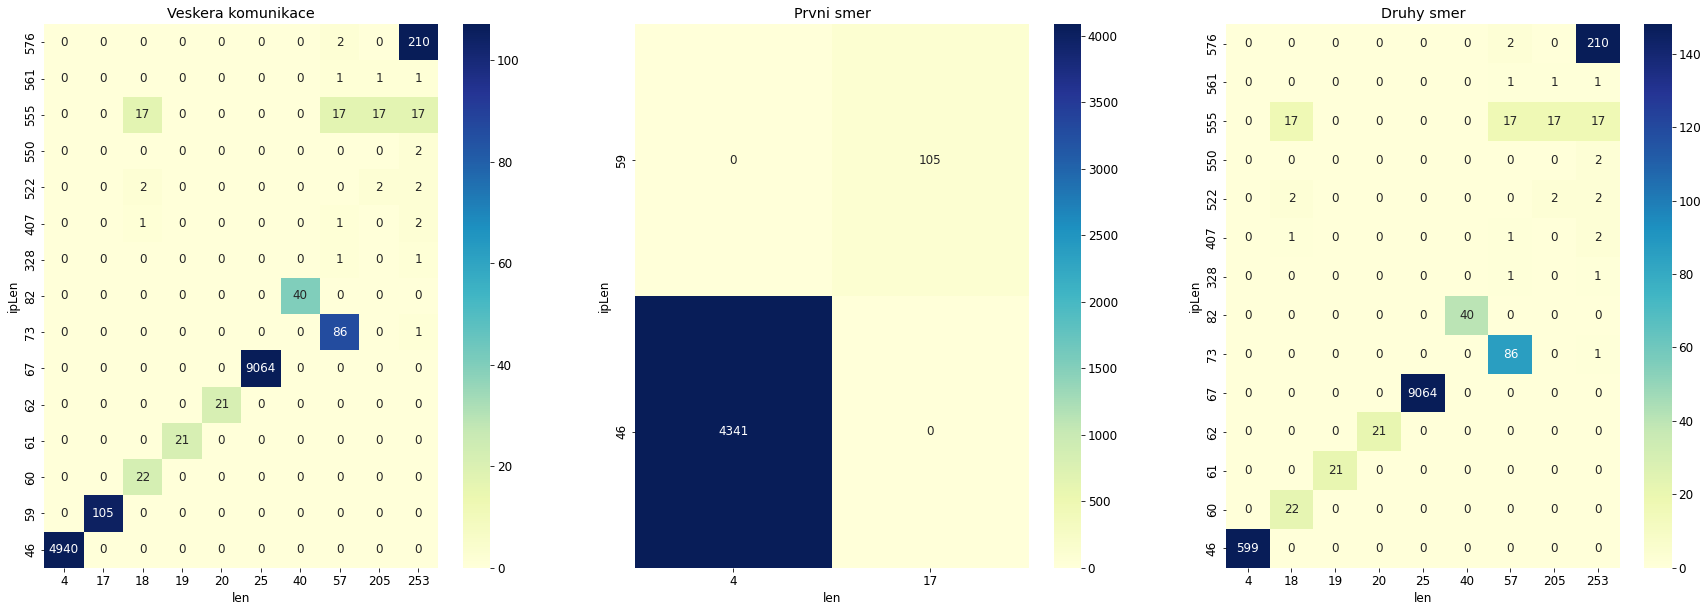

In [13]:

x = list(df.ipLen)
y = list(df.len)

x1 = list(df[df.commL4Id == 1].ipLen)
y1 = list(df[df.commL4Id == 1].len)

x2 = list(df[df.commL4Id == 2].ipLen)
y2 = list(df[df.commL4Id == 2].len)

# x: ipLen, y: len
def plot_heatmap(x, y, ax):
    # Pearson
    pearson_corr, _ = stats.pearsonr(x, y)
    print(f"Pearson: {pearson_corr:.3}")

    # Spearman
    spearman_corr, _ = stats.spearmanr(x, y)
    print(f"Spearman: {spearman_corr:.3}")

    d = dict()
    for a, b in zip(x, y):
        if (a, b) in d:
            d[(a, b)] += 1
        else:
            d[(a,b)] = 1

    # odstraneni duplicit
    x = list(set(x))
    y = list(set(y))

    x.sort(reverse=True)
    y.sort()

    result = []
    for i in x:
        row = []
        for j in y:
            if (i, j) in d:
                row.append(d[(i,j)])
            else:
                row.append(0)
        result.append(row)

    # fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(result, ax=ax, robust=True, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[str(i) for i in y], yticklabels=[str(i) for i in x])
    ax.set_xlabel("len")
    ax.set_ylabel("ipLen")


fig, axes = plt.subplots(1, 3, figsize=(30,10))

plot_heatmap(x, y, axes[0])
axes[0].set_title("Veskera komunikace")

plot_heatmap(x1, y1, axes[1])
axes[1].set_title(f"Prvni smer")

plot_heatmap(x2, y2, axes[2])
axes[2].set_title(f"Druhy smer")

# Poznamky

## Korelace

### Pearsonuv korelacni koeficient
- Snazi se napasovat linearni funkci `y=ax+b` na data.
- Cim lepe data kopiruji linearni funkci, tim vyssi index korelace je.

### Spearmanuv korelacni koeficint
- Kontorluje zda-li plati `y1 < y2` pro po sobe jdouci dvojice `x1 < x2`.
- Dava vysoke hodnoty pro funkci ktere jsou monotonni.

In [14]:
print(df.info())


print("----------")

print(df.uType.describe())
print(df.uType.value_counts())

print("----------")

print(df.asduType.describe())
print(df.asduType.value_counts())

print("----------")

print(df.numix.describe())
print(df.numix.value_counts())

print("----------")

print(df.cot.describe())
print(df.cot.value_counts())

print("----------")

print(df.oa.describe())
print(df.oa.value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14597 entries, 0 to 14596
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TimeStamp      14597 non-null  datetime64[ns]
 1   Relative Time  14597 non-null  float64       
 2   srcIP          14597 non-null  object        
 3   dstIP          14597 non-null  object        
 4   srcPort        14597 non-null  int64         
 5   dstPort        14597 non-null  int64         
 6   ipLen          14597 non-null  int64         
 7   len            14597 non-null  int64         
 8   fmt            14597 non-null  object        
 9   uType          1156 non-null   category      
 10  asduType       9657 non-null   category      
 11  numix          9657 non-null   category      
 12  cot            9657 non-null   category      
 13  oa             9657 non-null   category      
 14  addr           9657 non-null   float64       
 15  ioa            9657